**Содержание**:

1. [Библиотека streamlit](https://colab.research.google.com/drive/1C_qcUX8KnoS2N3-0FAHwCxdmp-f_vbxW?usp=sharing)
2. Создание веб-сервера

# Размещение модели нейронной сети на хостинге в интернете

## Создание и обучение модели, написание кода для работы модели в режиме распознавания

Для создания и обучения модели воспользуемся кодом из одного из предыдущих уроков. Вы можете для этих целей взять любую интересную вам задачу и модель. Здесь будем использовать линейную модель, обученную для решения задачи сегментации самолетов.

---
[Базовый блок | Сегментация изображений (Практика #3) | УИИ](https://colab.research.google.com/drive/18RT7WWfj2Z0ChSWNXLwyMDCeTEZ6vV0k?usp=sharing)

---

В конце этого этапа работы мы должны получить код для инициализации модели, загрузки ее весов (и сами веса, полученные в результате обучения). Также напишем код для предобработки изображения, подачи его в сеть и постобработки полученного предсказания.

Загрузим в Colab файл с весами модели:

In [ ]:
# Имя файла с весами модели
MODEL_NAME =   'model_air.h5'

In [ ]:
import gdown

# Загрузка файла модели из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l15/model_air.h5', None, quiet=True)

'model_air.h5'

Создадим программный файл с кодом для:
* инициализации модели;
* загрузки весов;
* работы модели в режиме распознавания;
* пред- и постобработки изображений.

In [ ]:
segment_file = '''

from tensorflow.keras.models import load_model
MODEL_NAME =   'model_air.h5'
import numpy as np
from PIL import Image 
model = load_model(MODEL_NAME)                                              # Загрузка весов модели
INPUT_SHAPE = (256, 456, 3)


def process(image_file):
    image = Image.open(image_file)  # Открытие обрабатываемого файла
    resized_image = image.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))          # Изменение размера изображения в соответствии со входом сети
    array = np.array(resized_image)[..., :3][np.newaxis, ..., np.newaxis]   # Регулировка формы тензора для подачи в сеть
    prediction_array = (255 * model.predict(array)).astype(int)             # Запуск предсказания сети
    prediction_array = np.split(prediction_array, 2, axis = -1)[0]          # Нулевой канал предсказания (значения 0 - самолет, 1 - фон)
    zeros = np.zeros_like(prediction_array)                                 # Создание массива нулей
    ones = np.ones_like(prediction_array)                                   # Создание массива единиц
    prediction_array_4d = np.concatenate([255 * (prediction_array > 100), zeros, zeros, 128 * ones], axis=3)[0].astype(np.uint8)  # Формирование тензора для наложения найденной маски
    mask_image = Image.fromarray(prediction_array_4d).resize(image.size)    # Преобразование тензора в изображение и подгонка его размера к исходному
    image.paste(mask_image, (0, 0), mask_image)                             # Добавление маски на исходное изображение
    return resized_image, prediction_array, image                           # Возврат исходного уменьшенного изображения, найденной маски и исходного изображения с наложенной маской
'''

with open('segment.py', 'w') as file:
    file.write(segment_file)

Проверим работу созданного скрипта. Для начала скачаем тестовое изображение самолета:

In [ ]:
# Загрузка тестовых изображений 10 классов

import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/knowledge/test_images.zip', None, quiet=True)

# Распаковка архива

!unzip -qo test_images.zip

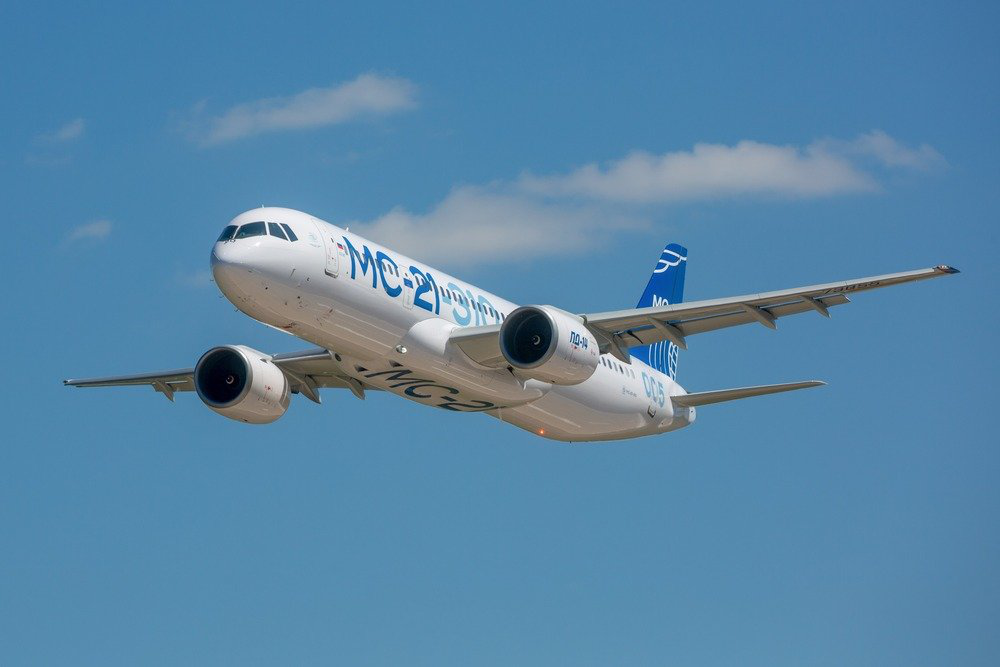

In [ ]:
# Просмотр тестового изображения

from PIL import Image                                    

# Путь к файлу изображения
test_path = '/content/test_images/1.jpg'  
img = Image.open(test_path)

# Вывод изображения на экран 
display(img)   

In [ ]:
# импорт модуля
import segment
import matplotlib.pyplot as plt

Вызываем функцию `process()` из модуля `segment`, передав путь к изображению самолета

In [ ]:
result = segment.process('/content/test_images/1.jpg')

Функция возвращает 3 изображения:
* оригинальное изображение самолета, уменьшенное до заданных внутри функции размеров
* полученную в результате сегментации маску изображения
* оригинальное изображение с наложенной маской

Вывдедем все три изображения на экран

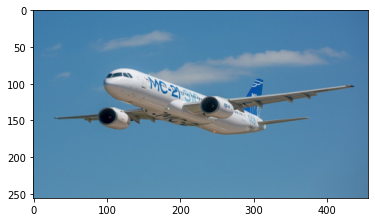

In [ ]:
# Отображаем оригинальное изображение
plt.imshow(result[0])
plt.show()

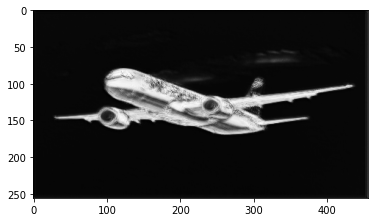

In [ ]:
# Отображаем маску
plt.imshow(result[1][0].squeeze(axis=2), cmap='gray')
plt.show()

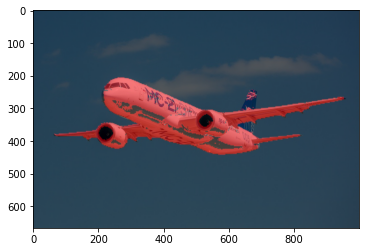

In [ ]:
# Отображаем оригинальное изображение c наложенной маской
plt.imshow(result[2])
plt.show()

## Создание сервиса с демонстрационной формой

Приступим к созданию демонстрационной формы для выбранной модели. Все создаваемые файлы вместе составят установочный набор, на который будет ориентироваться хостинг при развертывании вашего сервиса.

Создадим файл приложения (формы):

In [ ]:
app_file = '''

import streamlit as st
from PIL import Image 
from segment import process

st.title('Airplane segmentation demo')

image_file = st.file_uploader('Load an image', type=['png', 'jpg'])  # Добавление загрузчика файлов

if not image_file is None:                                           # Выполнение блока, если загружено изображение
    col1, col2 = st.beta_columns(2)                                  # Создание 2 колонок
    image = Image.open(image_file)                                   # Открытие изображения
    results = process(image_file)                                    # Обработка изображения с помощью функции, реализованной в другом файле
    col1.text('Source image')
    col1.image(results[0])                                           # Вывод в первой колонке уменьшенного исходного изображения
    col2.text('Mask')
    col2.image(results[1])                                           # Вывод маски второй колонке
    st.image(results[2])                                             # Вывод исходного изображения с наложенной маской (по центру)
'''

with open('app.py', 'w') as file:
    file.write(app_file)

Создадим файл конфигурации **Streamlit**:

In [ ]:
setup_file = '''

mkdir -p ~/.streamlit/
echo "\
[server]\n\
headless = true\n\
port = $PORT\n\
enableCORS = false\n\
\n\
" > ~/.streamlit/config.toml

'''

with open('setup.sh', 'w') as file:
    file.write(setup_file)

Создадим командный файл для запуска сервиса:

In [ ]:
proc_file = 'web: sh setup.sh && streamlit run app.py'

with open('Procfile', 'w') as file:
    file.write(proc_file)

Создадим файл требований необходимых пакетов:

In [ ]:
requirements_file = '''
streamlit==1.8.0
tensorflow-cpu==2.8.0
click<=8.0.4
'''

with open('requirements.txt', 'w') as file:
    file.write(requirements_file)

Удалим лишние файлы, находящиеся в текущей папке в Colab по умолчанию:

In [ ]:
!rm -rf sample_data
!rm -rf test_images
!rm test_images.zip

Существует множество различных хостингов, позволяющих размещать свои сервисы и открывать доступ к ним по интернету. Однако многие из них ориентированы на размещение веб-сервисов и не всегда подходят для сервисов, емких в отношении вычислений.
Большинство хостингов предоставляют свои услуги на платной основе, но нам для учебных целей достаточно ограничиться и бесплатной платформой.

Варианты:

    - Amazon EC2 - сервис AWS (Amazon Web Services), позволяющий арендовать  виртуальный сервер для вычислений и/или хостинга приложений.
    - PythonAnywhere - облачная платформа для запуска приложений на Python.
    - Heroku - облачная PaaS-платформа (Platform as a Service), поддерживающая ряд языков программирования, в том числе Python.

В рамках данного занятия используем платформу **Heroku** как наиболее удобную и позволяющую быстро развернуть приложение.

## Регистрация аккаунта на **Heroku**

Пройдите регистрацию аккаунта на Heroku по данной [ссылке](https://signup.heroku.com/dc).<br>
Этот шаг можно пропустить, если у вас уже есть аккаунт.<br>
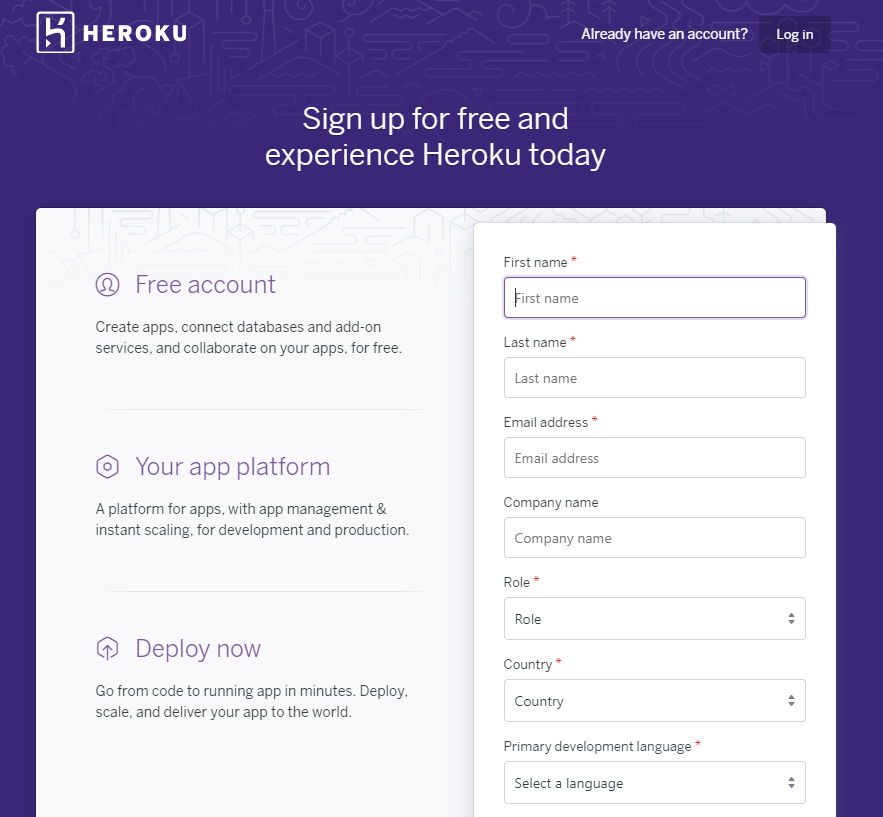

## Установка **Git** и **Heroku CLI**

Для развертывания сервиса в **Heroku** потребуется настроить и заполнить репозиторий **Git**.

**Git** - это система контроля версий для разработки на любых языках программирования. На данном занятии достаточно повторить показанные шаги; подробное изучение **Git** - тема отдельного курса.

Шаг с установкой **Git** можно пропустить, так как виртуальные машины Google Colab уже содержат предустановленный пакет **Git**.

Проверим наличие **Git**:

[Русскоязычная документация](https://git-scm.com/book/ru/v2) по Git

In [ ]:
!git --version

git version 2.17.1


Выполним начальную настройку **Git**: зададим имя пользователя и e-mail. Укажите свой email и имя-фамилию:

In [ ]:
!git config --global user.email "seregaak3@gmail.com"
!git config --global user.name "serega"

Установим инструменты командной строки **Heroku CLI** (Command Line Interface):

In [ ]:
!curl https://cli-assets.heroku.com/install-ubuntu.sh | sh > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1232  100  1232    0     0   5923      0 --:--:-- --:--:-- --:--:--  5894
+ dpkg -s apt-transport-https
+ echo 
+ apt-get update
+ apt-get install -y apt-transport-https
+ echo deb https://cli-assets.heroku.com/apt ./
+ dpkg -s heroku-toolbelt
+ true
+ curl https://cli-assets.heroku.com/apt/release.key
+ apt-key add -
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key output should not be parsed (stdout is not a terminal)
100  5393  100  5393    0     0  27100      0 --:--:-- --:--:-- --:--:-- 27100
+ apt-get update
+ apt-get install -y heroku
 ›   Warning: Our terms of service have changed: 
 ›   https://dashboard.heroku.com/t

Проверим правильность установки:


In [ ]:
!heroku --version

heroku/7.60.1 linux-x64 node-v14.19.0


Для авторизации в **Heroku** необходимо:

1. создать переменную **LOGIN** и поместить в нее ваш логин с **Heroku**;
2. создать переменную **API_KEY** и поместить в нее значение из поля **API Key** (перейти на [страницу с настройками Heroku](https://dashboard.heroku.com/account), прокрутить вниз).
3. создать файл **.netrc** в домашней папке с указанием логина и скопированного токена:

In [ ]:
LOGIN = 'seregaak3@gmail.com'  # Укажите свой логин
API_KEY = 'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx'  # Укажите свой API-key
           
auth_file = '''machine api.heroku.com
  login {login}
  password {password}
machine git.heroku.com
  login {login}
  password {password}
'''.format(login=LOGIN, password=API_KEY)

with open('/root/.netrc', 'w') as file:
    file.write(auth_file)

## Отслеживание проекта в Git

Прежде чем вы сможете развернуть свое приложение в **Heroku**, вам необходимо инициализировать локальный репозиторий **Git** и зафиксировать в нем код вашего приложения:

In [ ]:
!git init
!git add .
!git commit -m "My first commit"

Код вашего приложения теперь отслеживается в локальном репозитории **Git**. Он еще не отправлен на сервер **Heroku**.

## Создание удаленного репозитория **Heroku**

Git remotes - это версии вашего репозитория, которые находятся на других серверах. Вы развертываете свое приложение, отправляя его код на специальный удаленный сервер **Heroku**, связанный с вашим приложением.

Команда `heroku create` создает новое пустое приложение на **Heroku** вместе с соответствующим репозиторием **Git**. Если вы запустите эту команду из корневой папки вашего приложения, пустой репозиторий **Heroku Git** автоматически станет удаленным для вашего локального репозитория.

In [ ]:
!heroku create

Creating app... ⣾ 
⣽⣻⢿⡿⣟⣯Creating app... done, ⬢ murmuring-woodland-10687
https://murmuring-woodland-10687.herokuapp.com/ | https://git.heroku.com/murmuring-woodland-10687.git


Вы можете использовать команду `git remote`, чтобы проверить, что для вашего приложения установлен удаленный репозиторий с именем **heroku**:

In [ ]:
!git remote -v

heroku	https://git.heroku.com/murmuring-woodland-10687.git (fetch)
heroku	https://git.heroku.com/murmuring-woodland-10687.git (push)


## Развертывание кода

Чтобы развернуть приложение в Heroku, нужно использовать команду `git push`, которая отправит код из локального репозитория на удаленный сервер **heroku**:

In [ ]:
!git push heroku master

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 576 bytes | 576.00 KiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Compressing source files... done.
remote: Building source:
remote: 
remote: -----> Building on the Heroku-20 stack
remote: -----> Using buildpack: heroku/python
remote: -----> Python app detected
remote: -----> No Python version was specified. Using the same version as the last build: python-3.10.4
remote:        To use a different version, see: https://devcenter.heroku.com/articles/python-runtimes
remote: -----> Requirements file has been changed, clearing cached dependencies
remote: -----> Installing python-3.10.4
remote: -----> Installing pip 21.3.1, setuptools 57.5.0 and wheel 0.37.0
remote: -----> Installing SQLite3
remote: -----> Installing requirements with pip
remote:        Collecting streamlit==1.8.0
remote:          Downloading streamlit-1.8.0-py2.py3-none-any.whl 

Используйте эту же команду всякий раз, когда хотите развернуть в **Heroku** последнюю зафиксированную в репозитории версию вашего кода.

---

Обратите внимание, что **Heroku** развертывает только тот код, который вы отправляете в ветке **master** или **main**. Перенос кода в другую ветку удаленного репозитория **Heroku** не даст никакого эффекта.

---

## Проверка результа

В конце вывода ячейки с выполненой командой `git push heroku master` находится адрес страницы с демонстрационной формой (в нашем ноутбуке - это  https://murmuring-woodland-10687.herokuapp.com/)

Переходим по этой странице:<br>
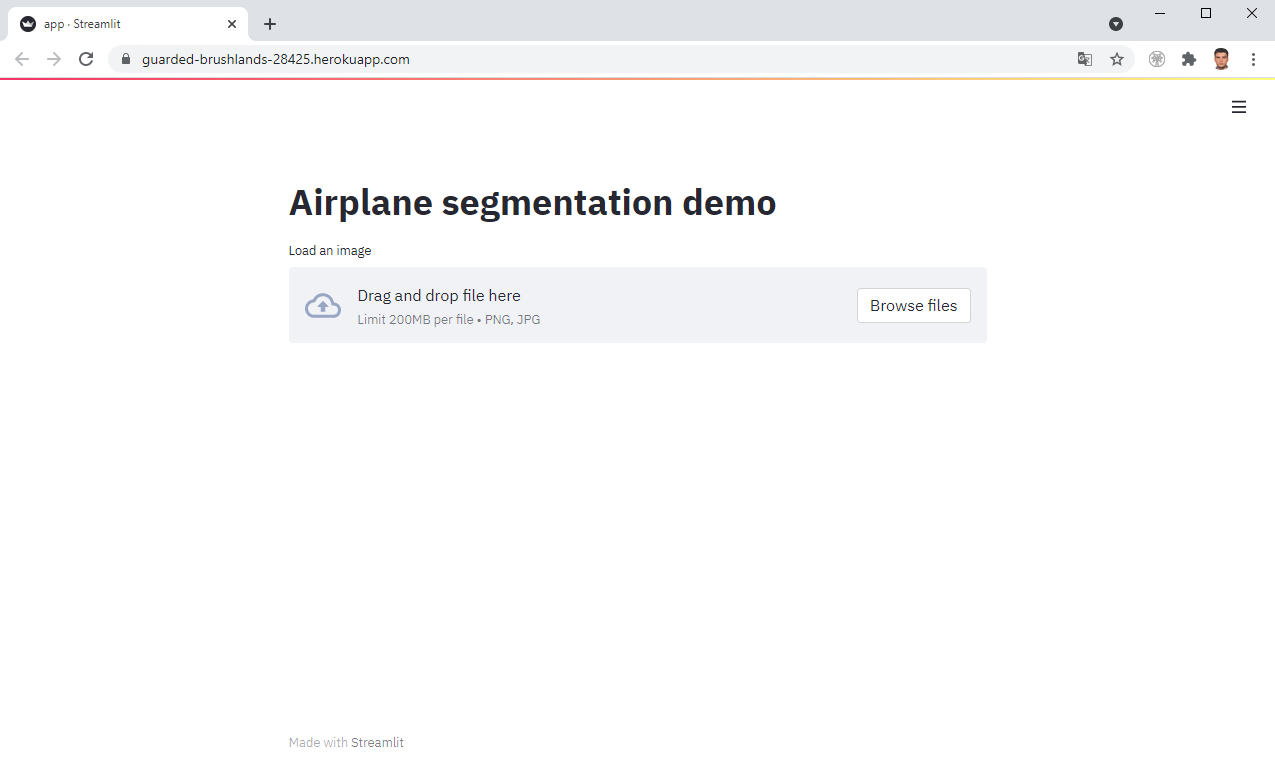

Загружаем изображение с самолетом и получаем следующий результат:



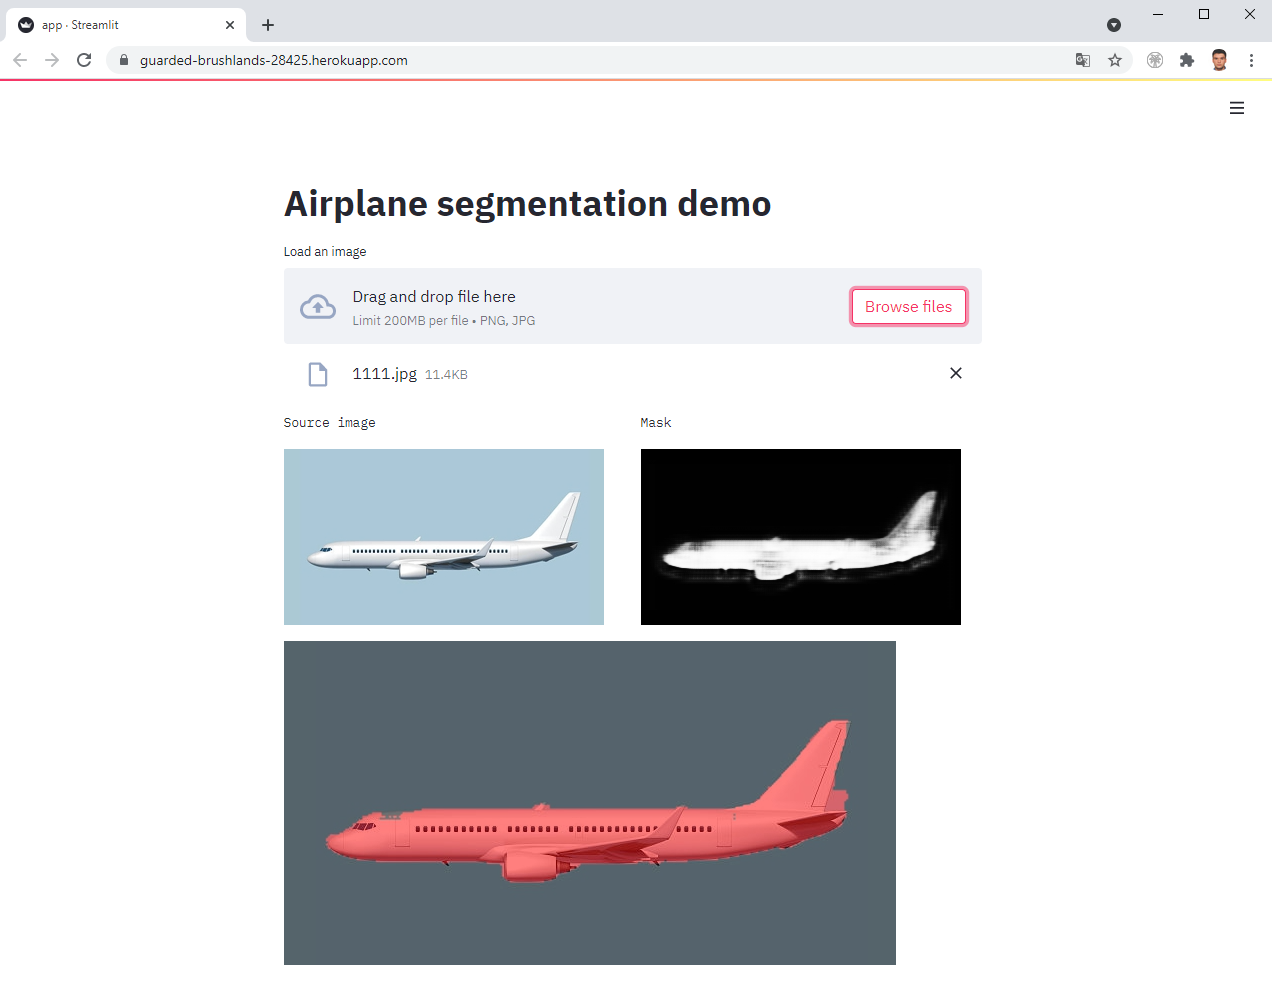

Примите поздравления!

Вы только что создали и разместили свою собственную модель нейросети в виде сервиса в интернете!

**Использованные материалы:**


In [ ]:
# https://proglib.io/p/sozdanie-interaktivnyh-paneley-s-streamlit-i-python-2021-06-21

# https://medium.com/nuances-of-programming/%D0%B1%D1%8B%D1%81%D1%82%D1%80%D0%B0%D1%8F-%D1%81%D0%B1%D0%BE%D1%80%D0%BA%D0%B0-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B4%D0%B0%D1%88%D0%B1%D0%BE%D1%80%D0%B4%D0%B0-%D1%81%D0%BE-streamlit-4b668ef25dc2

# https://blog.skillfactory.ru/kak-napisat-veb-prilozhenie-dlya-demonstratsii-data-science-proekta-na-python/

# https://habr.com/ru/post/568836/

# https://habr.com/ru/post/473196/

**Содержание**:

1. [Библиотека streamlit](https://colab.research.google.com/drive/1C_qcUX8KnoS2N3-0FAHwCxdmp-f_vbxW?usp=sharing)
2. Создание веб-сервера